# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

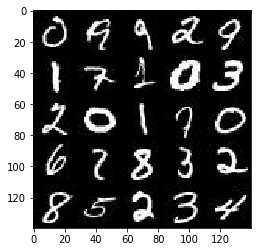

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

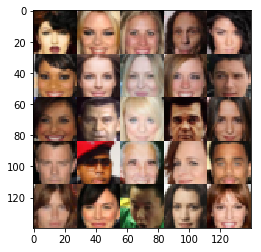

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [47]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3 or 28x28x1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 2, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512
        
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [49]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        # 28x28x out_channel_dim now

        out = 0.5 * tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)


Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [35]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Apply label smoothing to discriminator loss so it can generalize better
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake) * np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [36]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    print_every = 10
    show_every = 100
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, out_channel_dim, data_image_mode)
                    
            

        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.4670... Generator Loss: 0.0238
Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 3.0898
Epoch 1/2... Discriminator Loss: 1.8401... Generator Loss: 0.1733
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.4737
Epoch 1/2... Discriminator Loss: 1.5010... Generator Loss: 0.2394
Epoch 1/2... Discriminator Loss: 0.5091... Generator Loss: 3.6903
Epoch 1/2... Discriminator Loss: 0.5654... Generator Loss: 2.1546
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 0.9287
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 0.5670
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 1.3600


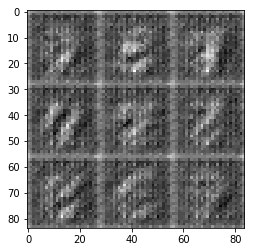

Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 2.6859
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 1.1377
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 0.9439
Epoch 1/2... Discriminator Loss: 0.6301... Generator Loss: 1.6391
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 2.2940
Epoch 1/2... Discriminator Loss: 0.6541... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 1.2613
Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 1.4701
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 2.7344


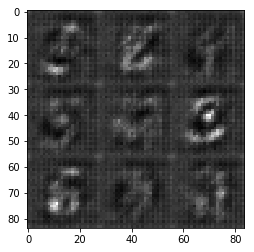

Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 2.1940
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 1.6065
Epoch 1/2... Discriminator Loss: 0.7465... Generator Loss: 1.5633
Epoch 1/2... Discriminator Loss: 0.6139... Generator Loss: 1.6405
Epoch 1/2... Discriminator Loss: 0.5494... Generator Loss: 1.7111
Epoch 1/2... Discriminator Loss: 0.6218... Generator Loss: 1.5029
Epoch 1/2... Discriminator Loss: 0.9554... Generator Loss: 0.5413
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 0.6878... Generator Loss: 0.9904
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 0.7238


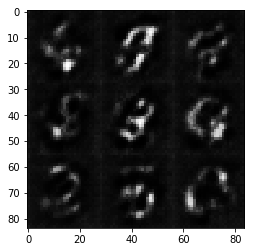

Epoch 1/2... Discriminator Loss: 0.6334... Generator Loss: 1.1061
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 0.3609
Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 1.0489
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 1.6395
Epoch 1/2... Discriminator Loss: 0.6214... Generator Loss: 1.1339
Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.9907
Epoch 1/2... Discriminator Loss: 0.6501... Generator Loss: 1.5790
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 1.0765


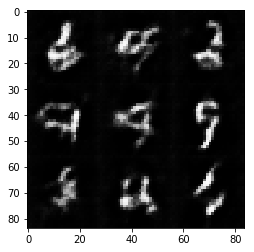

Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 0.9065
Epoch 1/2... Discriminator Loss: 0.6624... Generator Loss: 1.3632
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 1.4682
Epoch 1/2... Discriminator Loss: 0.7717... Generator Loss: 1.6928
Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.6690
Epoch 1/2... Discriminator Loss: 0.6405... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 0.6721... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 0.9859


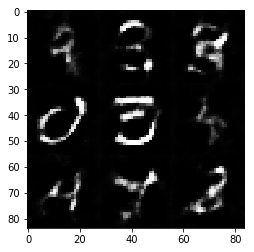

Epoch 1/2... Discriminator Loss: 0.7064... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 0.6281... Generator Loss: 1.1453
Epoch 1/2... Discriminator Loss: 0.6939... Generator Loss: 0.9905
Epoch 1/2... Discriminator Loss: 0.7702... Generator Loss: 0.9402
Epoch 1/2... Discriminator Loss: 0.6591... Generator Loss: 1.2315
Epoch 1/2... Discriminator Loss: 0.7376... Generator Loss: 0.9697
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 1.9291
Epoch 1/2... Discriminator Loss: 0.7292... Generator Loss: 1.3740
Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 0.8466... Generator Loss: 0.7206


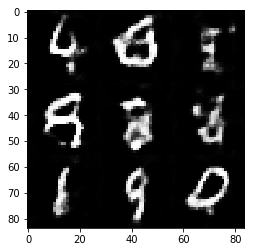

Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 0.7664
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 0.7444... Generator Loss: 0.9790
Epoch 1/2... Discriminator Loss: 0.6141... Generator Loss: 1.1552
Epoch 1/2... Discriminator Loss: 0.9489... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 0.7672... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 0.7564... Generator Loss: 1.7664
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.3183
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 0.6500... Generator Loss: 1.0233


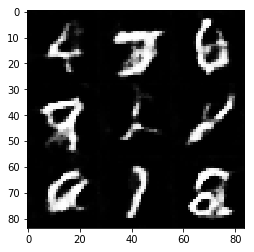

Epoch 1/2... Discriminator Loss: 0.6473... Generator Loss: 0.9961
Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.2518
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 0.9587... Generator Loss: 0.5603
Epoch 1/2... Discriminator Loss: 0.7408... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 1.1685
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 0.8033
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.5365
Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 0.7111


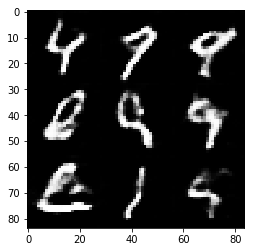

Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 0.8491
Epoch 1/2... Discriminator Loss: 0.6629... Generator Loss: 1.3555
Epoch 1/2... Discriminator Loss: 0.6901... Generator Loss: 1.7600
Epoch 1/2... Discriminator Loss: 0.6929... Generator Loss: 1.2642
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 0.3448
Epoch 1/2... Discriminator Loss: 0.6776... Generator Loss: 1.3720
Epoch 1/2... Discriminator Loss: 0.7914... Generator Loss: 1.0108
Epoch 1/2... Discriminator Loss: 0.6542... Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 0.9030... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 0.7147... Generator Loss: 1.2585


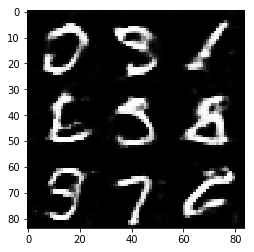

Epoch 1/2... Discriminator Loss: 0.8977... Generator Loss: 0.6409
Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 0.4517
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 0.7455... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 0.6986... Generator Loss: 1.0086
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 0.9901
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 0.7362... Generator Loss: 0.9197
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 0.7844
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 0.7484


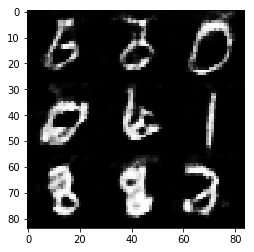

Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 0.8945
Epoch 2/2... Discriminator Loss: 0.7422... Generator Loss: 0.9320
Epoch 2/2... Discriminator Loss: 0.7282... Generator Loss: 0.9075
Epoch 2/2... Discriminator Loss: 0.9201... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 0.8435... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 0.8338... Generator Loss: 0.7616
Epoch 2/2... Discriminator Loss: 0.6739... Generator Loss: 1.2601
Epoch 2/2... Discriminator Loss: 0.9147... Generator Loss: 0.5945
Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 1.1283


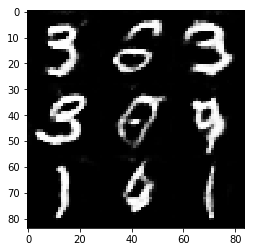

Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 0.6957... Generator Loss: 1.8167
Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 0.6085
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 0.6330
Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 0.6680
Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 2.1303
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.5428
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.3146
Epoch 2/2... Discriminator Loss: 0.9145... Generator Loss: 0.6272


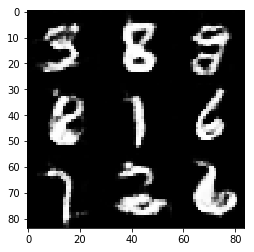

Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 1.3912
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 1.3893
Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 1.2889
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 0.9648... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.6460


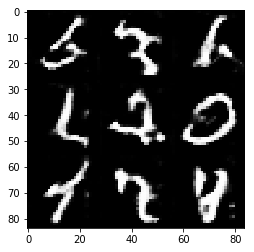

Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.5793
Epoch 2/2... Discriminator Loss: 0.6784... Generator Loss: 1.5528
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.0552
Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 0.3948
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 0.6241... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 0.4663
Epoch 2/2... Discriminator Loss: 0.9830... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 0.3445
Epoch 2/2... Discriminator Loss: 0.6442... Generator Loss: 1.4764


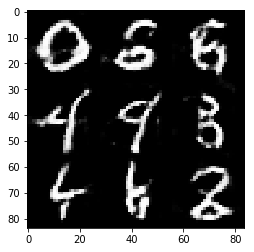

Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 0.7065
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.2995
Epoch 2/2... Discriminator Loss: 0.7918... Generator Loss: 0.7629
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 0.6492
Epoch 2/2... Discriminator Loss: 0.6725... Generator Loss: 1.2645
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.5051
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 1.0601
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.4465
Epoch 2/2... Discriminator Loss: 3.8145... Generator Loss: 4.6427


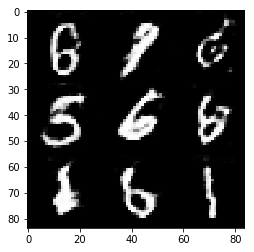

Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 1.5370
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.1027
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 0.4540
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.3341
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 0.7096
Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 0.6235
Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 1.8849
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 0.5978


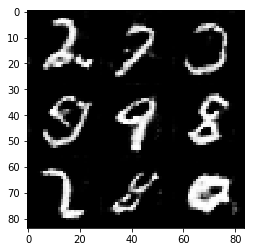

Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 0.6291... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 0.6065... Generator Loss: 1.6677
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 1.2754
Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 0.4375
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 2.2256... Generator Loss: 3.1608
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 0.5168
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 0.4847


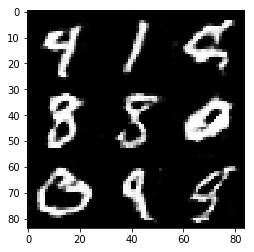

Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 1.1484... Generator Loss: 0.4766
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 0.6498
Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 1.3939
Epoch 2/2... Discriminator Loss: 0.7085... Generator Loss: 1.3540
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 0.6677
Epoch 2/2... Discriminator Loss: 1.2597... Generator Loss: 0.3478
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.1342


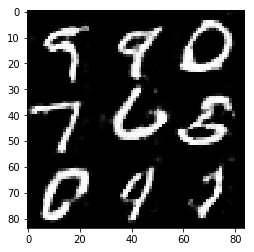

Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 0.8606... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 0.7218... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 0.6827... Generator Loss: 1.3623
Epoch 2/2... Discriminator Loss: 0.6800... Generator Loss: 0.8938
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.3682


In [50]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.6807
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.4762
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 2.9423
Epoch 1/1... Discriminator Loss: 1.6139... Generator Loss: 5.3887
Epoch 1/1... Discriminator Loss: 1.9133... Generator Loss: 6.6608
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 3.8707
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.0018


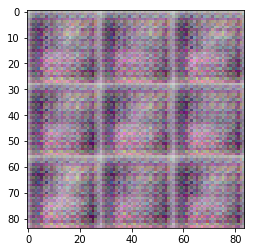

Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 2.8806
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 1.3905
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.9372
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.6807
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.9696


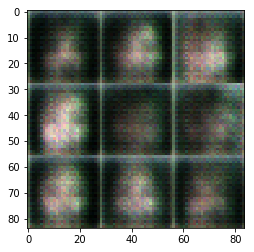

Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.2926
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 2.3188
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.7543
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.0168


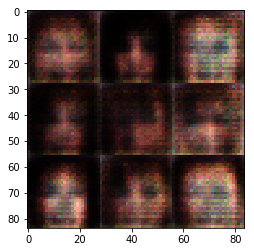

Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 2.3365
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.7433
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 1.9339
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.5225
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 2.0300
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.5266


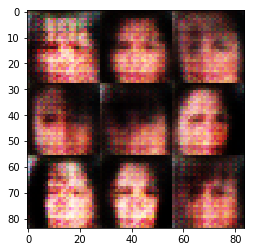

Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.7877
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.3508
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 2.5456
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.1900


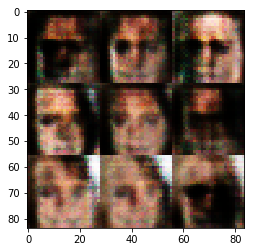

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 3.1612
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.5741
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.4641
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.2863


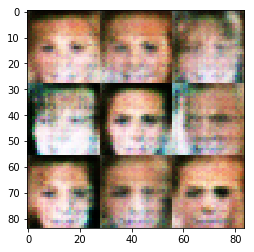

Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.9703
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 3.1070
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.2642


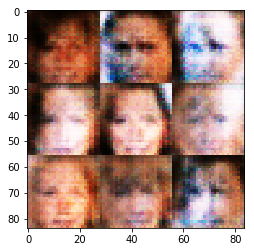

Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.5604
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.5694
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6558


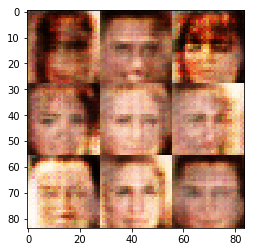

Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.5812
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.8059


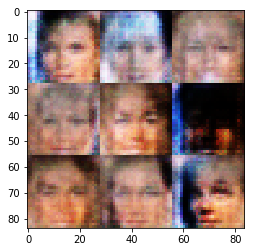

Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.7997
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.3026
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.9945


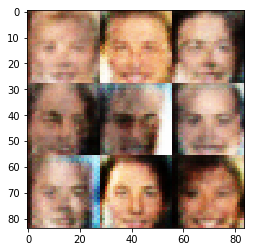

Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 1.9858
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.8294


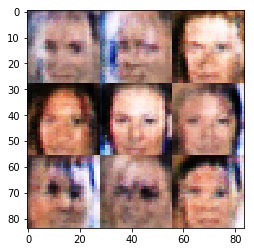

Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.3585
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.4124
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.8451


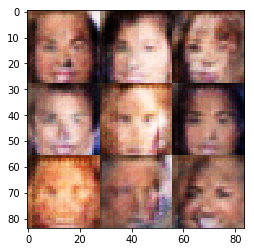

Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 2.2292
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.6422


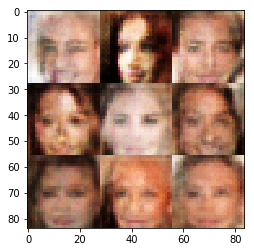

Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.7109


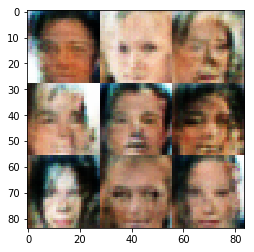

Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.3922
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.3282
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.1130


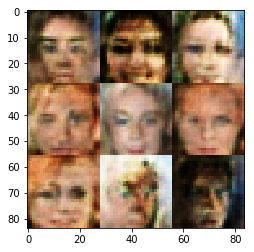

Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.9664


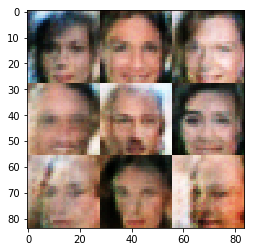

Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.7053
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.7355


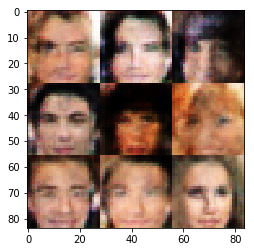

Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.5306


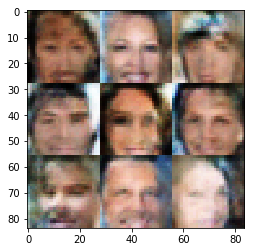

Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 1.2337
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.2330


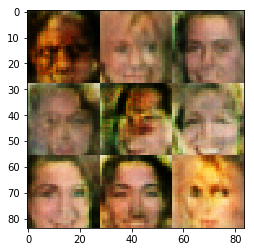

Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.9029
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.0250


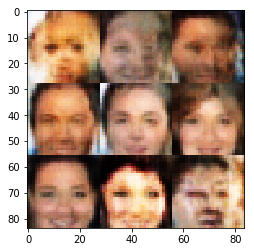

Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.4885
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.7014
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.7981


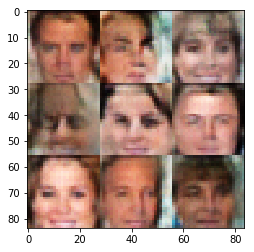

Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.4090


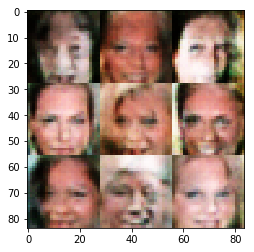

Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.6491


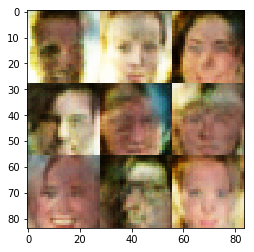

Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 1.8958


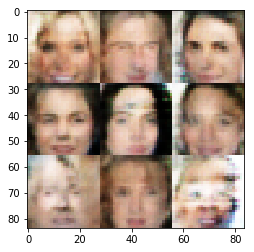

Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.5376
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.5439


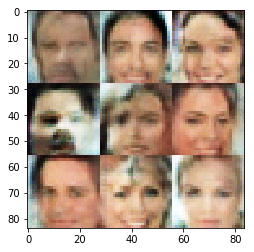

Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.4505
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.1661
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.2638


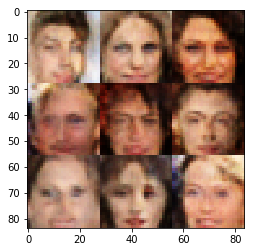

Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.7562


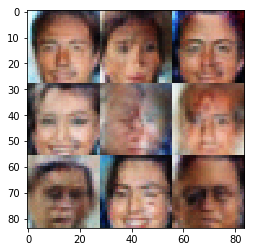

Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.1523
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5553


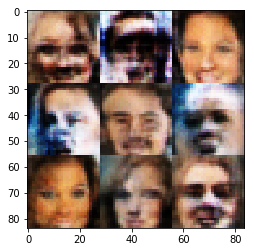

Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.5902
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.4131


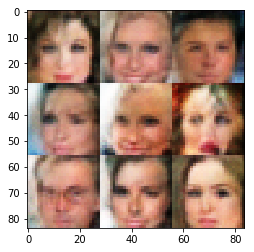

Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.2626
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.6593


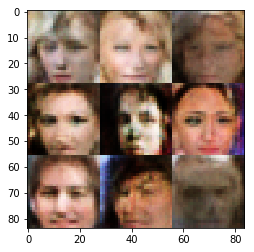

Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.3855


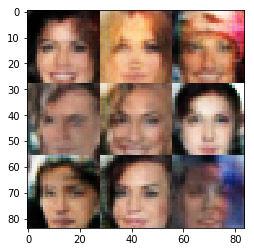

Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.6596


In [51]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.